# EDA и предобработка данных

In [1]:
from bs4 import BeautifulSoup
from markdown import markdown

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline
sns.set(style='whitegrid')

## Загрузка данных. EDA

In [2]:
# Загрузка исходных датасетов и их объединение
train_data = pd.read_csv("data/initial/nlbse23-issue-classification-train.csv")
test_data = pd.read_csv("data/initial/nlbse23-issue-classification-test.csv")
data = pd.concat([train_data, test_data], ignore_index=True)

In [3]:
# Десять случайных записей в исходном датасете
data.sample(10)

,id,labels,title,body,author_association
159300,1092889640,feature,Create and manipulate posts,"**User Stories**\r\n\r\n* As a user, I can cre...",OWNER
399764,1118803672,bug,bug: Cannot read properties of undefined (read...,### Describe the Bug\r\n\r\nAny ideas or point...,NONE
639653,557980306,bug,Filters not processed for Sse responses,**Describe the bug**\r\nI am running a client ...,NONE
620378,797420143,feature,Bench: develop cloudmesh provider for atmosphere,NaN,MEMBER
232515,1375936742,bug,横向排版 shift+click 从右向左无效,https://ld246.com/article/1663036247544,MEMBER
978061,1254155643,bug,Linux hosted functions stopped working,From today (31-05-2022) all my Linux Azure Fun...,NONE
371271,1272441546,question,Diff is not fine-grained,The AST diff for the patch - https://github.co...,CONTRIBUTOR
435737,1178294166,bug,pyplot_backend Imports backend_qt5agg Even For...,Viewrendered installs a qt graphics backend to...,CONTRIBUTOR
391028,684076155,bug,attribute-error ignores parent variable annota...,Example:\r\n```\r\nclass BaseFoo:\r\n x: in...,NONE
1181865,1331670957,bug,Heading levels should only increase by one,Category : Accessibility \r\n\r\n```\r\n<h3 cl...,OWNER


In [4]:
# Размер исходного датасета
data.shape

(1418201, 5)

In [5]:
# Типы столбцов
data.dtypes

id                     int64
labels                object
title                 object
body                  object
author_association    object
dtype: object

In [6]:
# Пустые значения
data.isnull().sum()

id                       0
labels                   0
title                    4
body                  5147
author_association       0
dtype: int64

In [7]:
# Дублирующиеся значения
data.duplicated().sum()

36411

In [8]:
# Пример содержимого колонки body
data.body[20]

'Code from `aioredis` was incorporated into the official `redis` package in v4.2 to adopt the async support.  As a result, `aioredis` will no longer be well maintained.  The switch to `redis` will be relatively painless since the functions+parameters are basically the same.\r\n\r\nReferences:\r\n\r\n- https://github.com/aio-libs/aioredis-py#-aioredis-is-now-in-redis-py-420rc1-\r\n- https://github.com/redis/redis-py#python-notice'

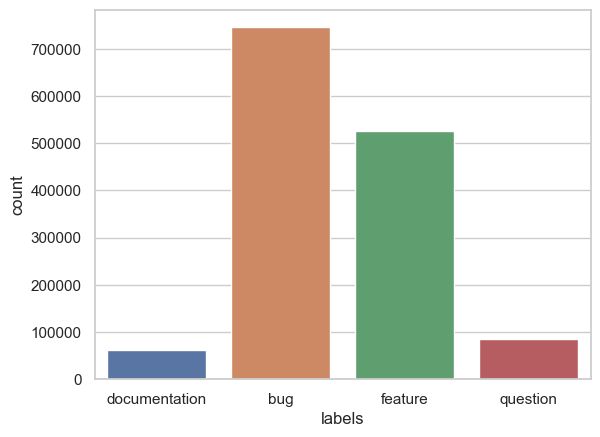

In [9]:
# Распределение меток в исходном датасете
sns.countplot(data=data, x='labels')
plt.show()

## Предобработка данных

Для корректной работы будущих моделей необходимо:
 - Удалить все дублирующмеся строки;
 - Удалить все пустые строки;
 - Избавиться от лишних столцов (id и author_association);
 - Преобразовать markdown-текст в обычный;
 - Соединить содержимое столбцов title и body в один столбец text;
 - Закодировать текстовые метки классов в цифровые.

Также можно уменьшить размер исходного датасета для увеличения сбалансированности классов.

In [10]:
# Удаление дубликатов
data_preprocessed = data.drop_duplicates()

In [11]:
# Удаление пустых строк
data_preprocessed = data_preprocessed.dropna()

In [12]:
# Удаление лишних столбцов
data_preprocessed = data_preprocessed.drop(columns=['id', 'author_association'])

In [13]:
def markdown_to_text(markdown_string):
    """ Конвертация markdown-текста to обычный текст """
    # md -> html -> text since BeautifulSoup can extract text cleanly
    html = markdown(markdown_string)

    # Удаление сниппетов
    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    # Удаление ссылок
    html = re.sub(r'<a href=(.*?)>(.*?)</a>', ' ', html)
    html = re.sub(r'https?://\S+', ' ', html)

    # Удаление изображений
    html = re.sub(r'<img (.*?)/>', ' ', html)



    # Удаление специальных символов
    html = re.sub(r'\s', ' ', html)

    # Удаление нескольких пробелов
    html = re.sub(r'\s\s+', ' ', html)

    # Извлечение текста
    soup = BeautifulSoup(html, 'lxml')
    text = ''.join(soup.findAll(string=True))

    return text

In [14]:
# Пример преобразования текста. ДО
data.body[1000]

'### What happened?\n\nJust successfully install boxbilling but cant login to admin. Detail & password all correct\n\n### BoxBilling Version\n\nv4.21\n\n### What version of PHP are you running?\n\nPHP 8.0\n\n### Additional Notes\n\nAdditional notes'

In [15]:
# Пример преобразования текста. ПОСЛЕ
markdown_to_text(data.body[1000])

'What happened? Just successfully install boxbilling but cant login to admin. Detail & password all correct BoxBilling Version v4.21 What version of PHP are you running? PHP 8.0 Additional Notes Additional notes'

In [16]:
# Уменьшение датасета
data_question = data_preprocessed[data_preprocessed.labels == "question"]
data_documentation = data_preprocessed[data_preprocessed.labels == "documentation"]
data_bug = data_preprocessed[data_preprocessed.labels == "bug"].sample(100000, random_state=7)
data_feature = data_preprocessed[data_preprocessed.labels == "feature"].sample(100000, random_state=7)

data_preprocessed_reduced = pd.concat([data_question, data_documentation, data_bug, data_feature])
data_preprocessed_reduced = data_preprocessed_reduced.reset_index(drop=True)

In [17]:
data_preprocessed_reduced = data_preprocessed_reduced.drop([189465, 189466, 189467, 189468, 189469, 189470,
                                                            204171, 204172, 204173, 204174,204175])
data_preprocessed_reduced = data_preprocessed_reduced.reset_index(drop=True)

In [18]:
# Размер нового датасета
data_preprocessed_reduced.shape

(344110, 3)

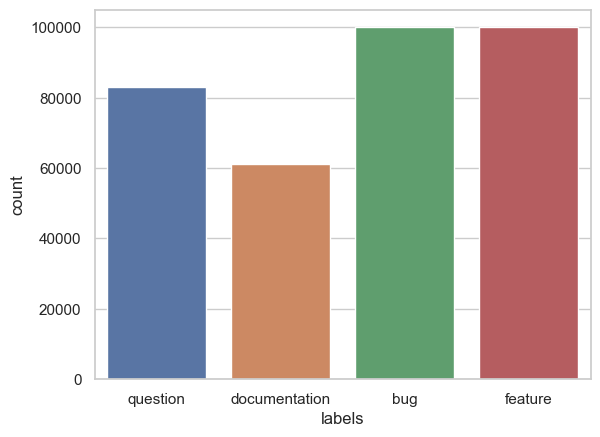

In [19]:
# Распределение меток в новом датасете
sns.countplot(data=data_preprocessed_reduced, x='labels')
plt.show()

In [20]:
%%time
# Преобразование текста в колонке body
data_preprocessed_reduced["body"] = data_preprocessed_reduced["body"].map(lambda x: markdown_to_text(x))

CPU times: total: 9min 33s
Wall time: 9min 42s


In [21]:
# Объединение колонок title и body в колонку context
data_preprocessed_reduced['text'] = data_preprocessed_reduced['title'] + '. ' + data_preprocessed_reduced['body']

In [22]:
# Удаление ненужных столбцов
data_final = data_preprocessed_reduced.drop(columns=['title', 'body'])

In [23]:
# Кодирование колонки label
data_final_encoded = data_final.copy()
data_final_encoded['labels'] = data_final_encoded['labels'].map({'bug' : 0, 'feature' : 1, 'documentation' : 2, 'question' : 3})

In [24]:
# Выборка из финальной закодированной таблицы
data_final_encoded.sample(10, random_state=7)

,labels,text
317538,1,[ExecuteTx] Review screen: overall UI. Scrolla...
91752,2,Is ScreenDetails supposed to inherit from Even...
105517,2,"Add use case, Edit command. Add a use case for..."
156188,0,User is not able to launch pgadmin4 4.25 (RM ...
135946,2,Publish API documentation on the website. Add ...
99232,2,Update Sysmon Dictionary (Windows) - Event 4. ...
185913,0,explain the error. ⚠️ This is for issues with ...
77938,3,Why multiple enums with same value are allowed...
70689,3,[clkmgr] Double check transactional clock enab...
245068,1,Meter data responsible sends time series and r...


In [25]:
# Сохранение датасетов в CSV-формате
data_final.to_csv("data/preprocessed/issue_data.csv", sep=",", index=False)
data_final_encoded.to_csv("data/preprocessed/issue_data_encoded.csv", sep=",", index=False)